In [21]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [22]:
np.random.seed(1)
torch.manual_seed(1)
torch.set_default_dtype(torch.float)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [23]:
data       = np.load("./data/ecg_data.npz")
Xtr        = torch.tensor(data["Xtr"]).type(torch.float).to(device)    #Clean train
Xtr_noise  = torch.tensor(data["Xtr_noise"]).type(torch.float).to(device)  #Noisy train
Xte_noise  = torch.tensor(data["Xte_noise"]).type(torch.float).to(device)  #Noisy test

params = np.load("./data/ecg_params.npz")
W = torch.FloatTensor(params["W"]).type(torch.float).to(device)  #Decoder parameters
V = torch.FloatTensor(params["V"]).type(torch.float).to(device)  #Encoder parameters

In [31]:
# write an RNN class with all its methods
class RNNAE(nn.Module):
    def __repr__(self):
        return {"model":"RNN","HS":self.hidden_size,"NL":self.num_layers}
    
    def __init__(self, input_size, hidden_size, num_layers,epoch=1000,lr=0.001):
        super(RNNAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.epochs=epoch
        self.lr=lr
        self.criterion=nn.MSELoss()

        # RNN architecture
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,nonlinearity="relu")
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out
    
    def loss(self,X,X_hat):
        return self.criterion(X,X_hat).item()
    
    
    def fit(self,X,R):
        train_loss_list=[]
        optimizer=optim.Adam(self.parameters(),lr=self.lr)
        for epoch in range(self.epochs+1):
            train_loss = 0.0
            self.train()
            optimizer.zero_grad()
            output = self.forward(X)
            loss = self.criterion(output, R)
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss)
            if(epoch%100==0):print('Epoch [{}/{}], Train Loss: {:.9f}'.format(epoch, self.epochs, loss))
        #self.saver(self.model.state_dict())
        return loss.item()

    def test(self,X,R):
        self.eval()
        with torch.no_grad():
            output=self.model(X)
            loss=self.criterion(output,R)
            return loss

    def print_param(self):
        for param in self.parameters():
            print(f'parameter shape:{param.shape}')
            #print(f'parameter value:{param.data}')
    
    @staticmethod
    def plot_loss(X,X_hat):
        time=len(X)
        plt.plot(range(1, time+1), X.cpu().detach().numpy(), label='Noisy Data')
        plt.plot(range(1, time+1), X_hat.cpu().detach().numpy(), label='Reconstructed Data')
        plt.xlabel('Time')
        plt.ylabel('ECG')
        plt.title('Noisy Data vs. Reconstructed Data')
        plt.legend()
        plt.show()

    def saver(self,best_weights,PATH="./models"):
        name=''.join(f"{key}{val}" for key, val in self.__repr__().items())
        path=PATH+"/"+name
        torch.save(best_weights,path)




In [33]:
model=RNNAE(100,8,1,epoch=100,lr=0.1).to(device)
model.fit(Xtr_noise,Xtr)

Epoch [0/10], Train Loss: 6.648929119


2.108797073364258

In [34]:
X_pred=model(Xte_noise[:5])

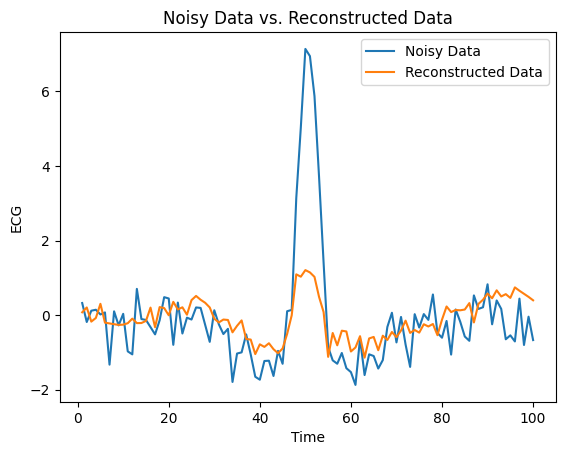

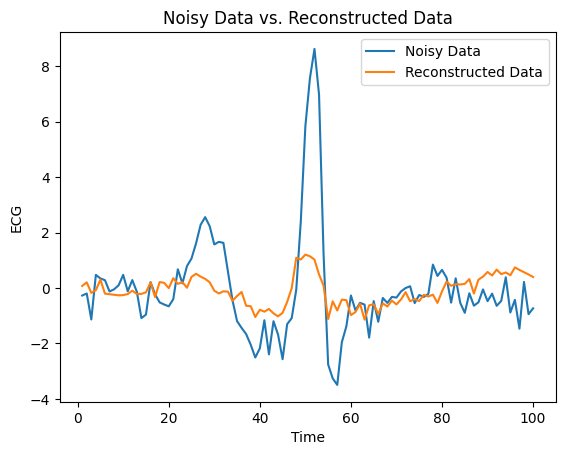

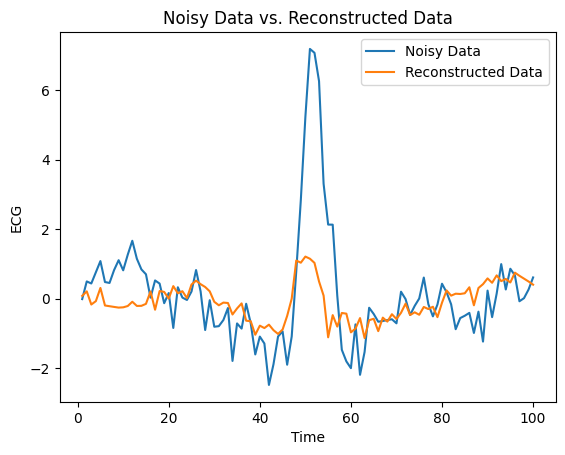

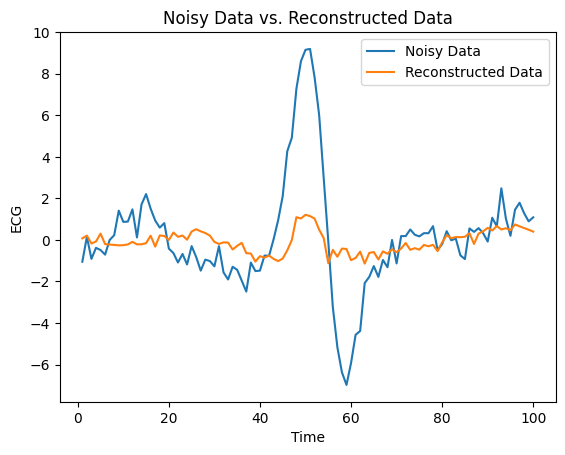

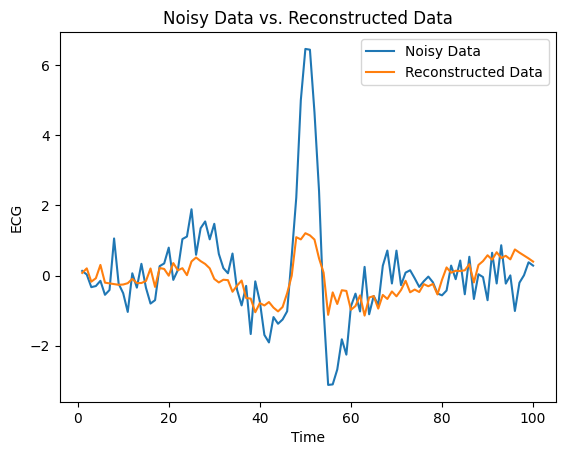

In [35]:
for i in range(5):
    model.plot_loss(Xte_noise[i],X_pred[i])